# <span style="color:green"> Run on python 3.6</span>

# Explanations:

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных. (но можно добавлять некоторые параметры в ядро и их градиентными методами "обучать", потому что все что мы делаем - перемножаем матрицы и используем элементарные функции)

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

ПРОТЕСТИТЬ, ЧТОБЫ ОДИН ГПР ИЛИ ОДНА СЕТКА МОГЛИ ЗАФТИТИТЬ ЗАВИСИМОСТЬ ДЛЯ ОДНОЙ КОМПОНЕНТЫ

In [19]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [20]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

---

# Hyperparameters:

In [21]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 3     # число атомов
    K = 5     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 64

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [22]:
f'p: {CFG.p}, r_cut: {CFG.r_cut}'

'p: [1.23475109 2.36993749 1.87522212 2.11245865 1.73416064], r_cut: [9.35062068 7.91138464 6.3941947  5.92955616 7.05550064]'

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [23]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [24]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [25]:
from sklearn.preprocessing import normalize

In [26]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [27]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X, A

In [28]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [29]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [30]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold, f_min_threshold=CFG.f_min_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    Также убирает нижни силы, меньше f_min_threshold

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) < f_min_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [31]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.pinv(A)

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number)
            
            if transform:
                x = transform(x)
            else:
                x = torch.tensor(x)
            x = x.to(torch.float)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)

            dataset.append(
                (torch.flatten(x), torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [32]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 1.1201671361923218
std = 0.3449265956878662

In [33]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [35]:
dataset = create_tensor_dataset(coords_file_path='coords3.csv', forces_file_path='forces3.csv', step=30)

# Uncomment, when calculated and changed mean and std:

# dataset = create_tensor_dataset('coords2.csv', 'forces2.csv', step=40, transform=transform)

Progress for atom 2: 100%|██████████| 164/164 [00:00<00:00, 350.18it/s]


In [36]:
torch.save(dataset, str(CFG.N) + 'dataset_K_' + str(CFG.K) + '.pt')

In [37]:
# Проверка того, что при домножении на псведообратную матрицу получаем нужный вектор силы
t = dataset[0]
pinvA = t[2]
f = t[1]
F_3d = t[3]

F_3d, pinvA @ f

(tensor([ 0.0991,  0.6620, -0.7275]), tensor([ 0.0991,  0.6620, -0.7275]))

Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [38]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[1][0].size(), train_data[1][0]

(torch.Size([25]),
 tensor([1.6019, 1.6018, 1.6019, 1.6019, 1.6019, 1.7543, 1.7544, 1.7543, 1.7543,
         1.7543, 1.6589, 1.6588, 1.6589, 1.6589, 1.6589, 1.6767, 1.6766, 1.6767,
         1.6767, 1.6767, 1.6578, 1.6577, 1.6578, 1.6578, 1.6578]))

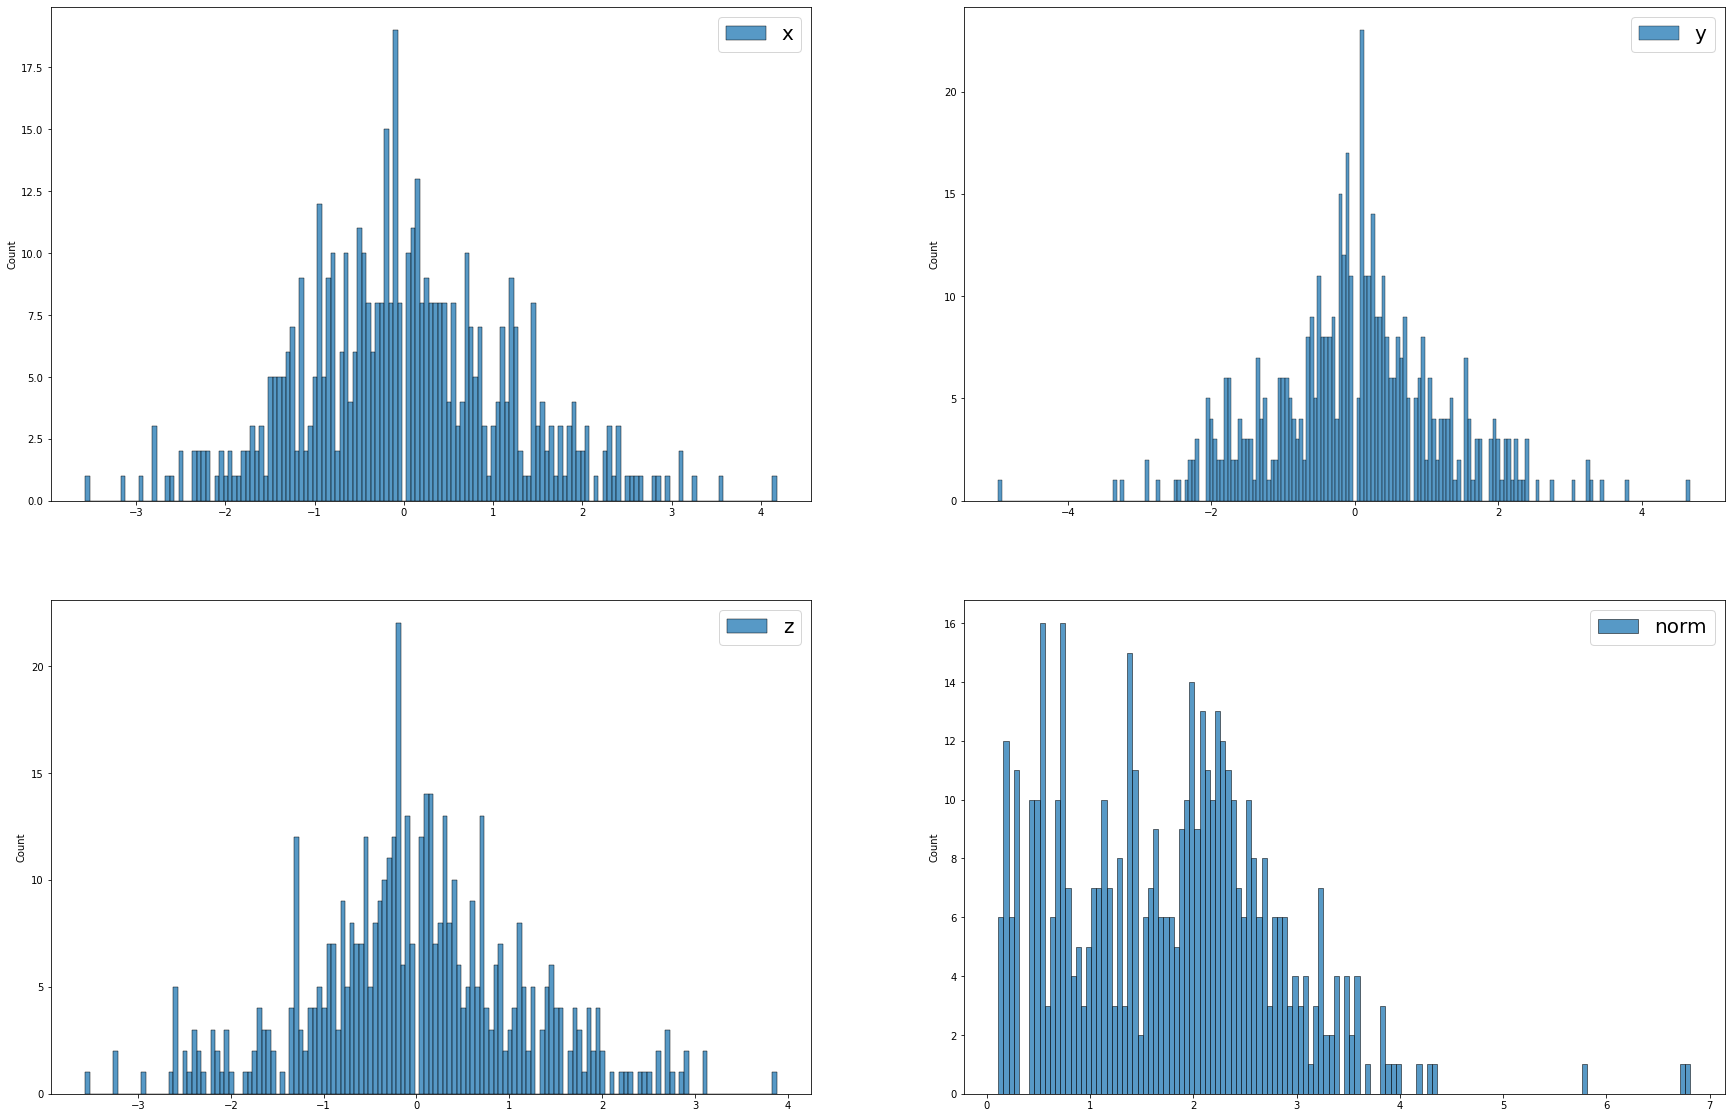

In [39]:
def plot_target_distribution(data=dataset, figsize=(30, 20), fontsize=20):
    '''
    data: data in 
    '''
    target_3D = torch.stack([elem[3] for elem in data])
    x, y, z = list(map(lambda x: torch.stack(x), list(zip(*list(target_3D)))))
    target_3D = np.array(target_3D)
    target_norm = norm(target_3D, axis=-1)
    data = {'x': x, 'y': y, 'z': z, 'norm': target_norm}

    plt.figure(figsize=figsize)

    for (i, key) in enumerate(data):
        plt.subplot(2, 2, i + 1)
        ax = plt.gca()
        sns.histplot(data[key], label=f'{key}', stat='count', binwidth=0.05, ax=ax)
        plt.legend(loc='best', fontsize=fontsize)
    
    plt.show()


plot_target_distribution()

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [40]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 1.5471229553222656, std = 0.2834112346172333


## Когда молекул уже будет много как хранить данные:

In [ ]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [41]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [42]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [43]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [44]:
# next(iter(train_loader))[0]  # [batch_of_flattened_X, batch_of_k_dim_f, batch_of_pinv_a, batch_of_3d_f]

---

# Обучение:

## 1)Многомерный аутпут:

In [45]:
import torch.nn.functional as F
import torch.cuda.amp as amp

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [46]:
class MultiOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultiOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

        return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [47]:
class GaussianNLLLossWithReadyVar(nn.GaussianNLLLoss):
    '''

    Custom GaussianNLLLoss that does not require passing var into forward

    The targets are treated as samples from Gaussian distributions, so var is calculated on full train data, assuming it was taken from the same distribution

    '''
    def __init__(self, full=False, eps=1e-06, reduction='sum'):
        super().__init__(full=full, eps=eps, reduction=reduction)
        self.__var_vector = torch.std(torch.stack([elem[1] for elem in train_data]), dim=0)
        # self.__var = torch.ones(200, 10, requires_grad=True)
        self.reduction = reduction

    def forward(self, input, target):
        # неважно, что оно может делать mean еще по размерностям, это всего лишь домножение на константу
        var = torch.stack([self.__var_vector] * input.size(0)).to(CFG.device)

        return F.gaussian_nll_loss(input=input, target=target, var=var, reduction=self.reduction) / input.size(0)

In [48]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 8),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(8),

            nn.Linear(8, 32),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - это батч векторов т.ч.: size: [KxK], сам батч: (bath_size, KxK)

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [49]:
def plot_k_dim_f_norm_from_x_norm(data_sample, figsize=(15, 10), fontsize=18):
    '''

    Функция строит зависимость таргета от X

    data_sample - итерируемый объект из тьюплов вида: (x, f_k_dim, f_3d, pinv_A)

    '''
    plt.figure(figsize=figsize)
    x = torch.stack([elem[0][0].squeeze() for elem in data_sample])

    y = torch.stack([elem[1][0].squeeze() for elem in data_sample])

    plt.scatter(x, y, label='y(x)')
    plt.title('Зависимость $Y_{target}(X)$', fontsize=fontsize)
    None

if CFG.K == 1:
    plot_k_dim_f_norm_from_x_norm(dataset)

#### Функции уже для обучения:

В качестве метрики буду использовать сумму MSE по компонентам, лоссы можно разные пробовать

In [50]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None, scaler=amp.GradScaler()):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim, A_pinv, F_3D)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device).detach()   # здесь можно не делать detach и обучать матрицу A

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()
        processed_data += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

/Users/avarlamov/opt/anaconda3/envs/my_3_6_conda_env/lib/python3.6/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [51]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs, 2)).to(CFG.device) 
        outputs_3D = torch.squeeze(outputs_3D, -1)

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum')
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size

    print(inputs.size(), outputs.size())

    return val_loss, val_MSE

In [52]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=MultiOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
    return history

In [53]:
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict

In [54]:
# model = SingleNet(
#     output_size=CFG.output_size,

#     # activation=nn.Tanh(),
#     activation=nn.ReLU(),

# ).to(CFG.device)

model = nn.Sequential(
    nn.Linear(CFG.K ** 2, 8),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(8),

    nn.Linear(8, 256),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(256),

    nn.Linear(256, 512),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(512),

    nn.Linear(512, CFG.K)
)

optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

model

Sequential(
  (0): Linear(in_features=25, out_features=8, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=8, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=256, out_features=512, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=512, out_features=5, bias=True)
)

In [55]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    
    # scheduler=exp_scheduler,

    scaler=None,

    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    # criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    
    epochs=30
)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/Users/avarlamov/opt/anaconda3/envs/my_3_6_conda_env/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
epoch:  20%|██        | 6/30 [00:00<00:00, 26.09it/s]

torch.Size([35, 25]) torch.Size([35, 5])

Epoch 001 train_loss: 17.8479 val_loss 16.9593 train_MSE 660869.2314 val_MSE 861.2734
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 002 train_loss: 16.7312 val_loss 16.4502 train_MSE 367004.9183 val_MSE 3542.1028
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 003 train_loss: 16.4732 val_loss 16.2476 train_MSE 11459.8343 val_MSE 5896.8263
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 004 train_loss: 16.2276 val_loss 15.9897 train_MSE 46666.2593 val_MSE 6112.4237
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 005 train_loss: 16.0174 val_loss 15.5623 train_MSE 9317.7748 val_MSE 13530.8942
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 006 train_loss: 15.7367 val_loss 15.0865 train_MSE 11514.6821 val_MSE 8494.0660


epoch:  43%|████▎     | 13/30 [00:00<00:00, 29.30it/s]

torch.Size([35, 25]) torch.Size([35, 5])

Epoch 007 train_loss: 15.4942 val_loss 14.2661 train_MSE 32241.6776 val_MSE 36713.8006
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 008 train_loss: 15.2649 val_loss 14.8642 train_MSE 18508.1584 val_MSE 58692.5153
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 009 train_loss: 15.0307 val_loss 14.5839 train_MSE 32759.8411 val_MSE 5186.2841
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 010 train_loss: 14.7368 val_loss 15.0349 train_MSE 13753.1709 val_MSE 11717.3328
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 011 train_loss: 14.5717 val_loss 13.9376 train_MSE 36958.7458 val_MSE 20735.7224
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 012 train_loss: 14.2754 val_loss 15.9235 train_MSE 1830.8996 val_MSE 25485.3344
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 013 train_loss: 13.8275 val_loss 16.4349 train_MSE 24615.2439 val_MSE 11714.4133


epoch:  67%|██████▋   | 20/30 [00:00<00:00, 29.86it/s]

torch.Size([35, 25]) torch.Size([35, 5])

Epoch 014 train_loss: 13.5581 val_loss 15.6927 train_MSE 25757.8890 val_MSE 995020.4663
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 015 train_loss: 13.1642 val_loss 14.8593 train_MSE 12488.6740 val_MSE 563455.2638
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 016 train_loss: 12.8022 val_loss 24.2955 train_MSE 2808.9346 val_MSE 1026558.4294
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 017 train_loss: 12.4448 val_loss 15.1048 train_MSE 3598.1704 val_MSE 219538.6748
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 018 train_loss: 12.1040 val_loss 19.5647 train_MSE 15659.1403 val_MSE 3190.6693
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 019 train_loss: 11.6570 val_loss 11.2990 train_MSE 19994.6396 val_MSE 427294.5767
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 020 train_loss: 11.2412 val_loss 12.9051 train_MSE 12084.0732 val_MSE 104769.5215


epoch:  90%|█████████ | 27/30 [00:00<00:00, 30.13it/s]

torch.Size([35, 25]) torch.Size([35, 5])

Epoch 021 train_loss: 10.9790 val_loss 10.8061 train_MSE 9362.4081 val_MSE 5775.8401
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 022 train_loss: 10.6763 val_loss 9.2999 train_MSE 13313.7213 val_MSE 1064252.4663
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 023 train_loss: 10.3640 val_loss 8.8042 train_MSE 15368.9270 val_MSE 832249.7178
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 024 train_loss: 10.0241 val_loss 9.3011 train_MSE 43585.3228 val_MSE 1908629.7914
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 025 train_loss: 9.7871 val_loss 9.4977 train_MSE 28662.7346 val_MSE 170257.7178
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 026 train_loss: 9.5798 val_loss 12.5696 train_MSE 4527.7016 val_MSE 1283686.9693
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 027 train_loss: 9.4129 val_loss 13.4195 train_MSE 38583.1669 val_MSE 2209584.4908


epoch: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]

torch.Size([35, 25]) torch.Size([35, 5])

Epoch 028 train_loss: 9.2214 val_loss 11.7188 train_MSE 10230.2140 val_MSE 2881438.4294
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 029 train_loss: 9.0894 val_loss 15.9417 train_MSE 2499.7286 val_MSE 1601813.5951
torch.Size([35, 25]) torch.Size([35, 5])

Epoch 030 train_loss: 8.9892 val_loss 14.8963 train_MSE 6694.5858 val_MSE 1408351.0184


In [56]:
def make_predictions_and_plot(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=MultiOutputMSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''
    
    if CFG.K != 1:
        return

    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices).detach().numpy()
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    # metric = criterion(Y_pred, Y_target)
    
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    # fig.suptitle(f'Metric: {metric}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)

        plt.scatter(X_matrices, Ys[i].squeeze(), label=f'Y(X) {name}')

        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

In [57]:
if CFG.K == 1:
    make_predictions_and_plot(model=model, data=train_data, same_axis=True)

In [58]:
def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    names = ['Losses', 'Metrics']
    
    figure = plt.figure(figsize=figsize)

    train_loss, train_metric, val_loss, val_metric = list(zip(*history))

    parameters = {'Losses': [train_loss, val_loss], 'Metrics': [train_metric, val_metric]}

    for i, name in enumerate(names):

        plt.subplot(1, 2, i + 1)
        plt.plot(range(1, len(history) + 1), parameters[name][0], label='train_loss')
        plt.plot(range(1, len(history) + 1), parameters[name][1], label='val_loss')
        
        plt.title(names[i], fontsize=18)
        plt.xlabel('epoch', fontsize=16)
        plt.ylabel('value', fontsize=16)     
        plt.xticks(np.arange(1, len(history) + 1, 1))
        # plt.yticks(np.arange(1, len(history) + 1, 1))
        plt.legend(loc='best', fontsize=16)
        plt.grid(alpha=0.4)
    
    plt.show()

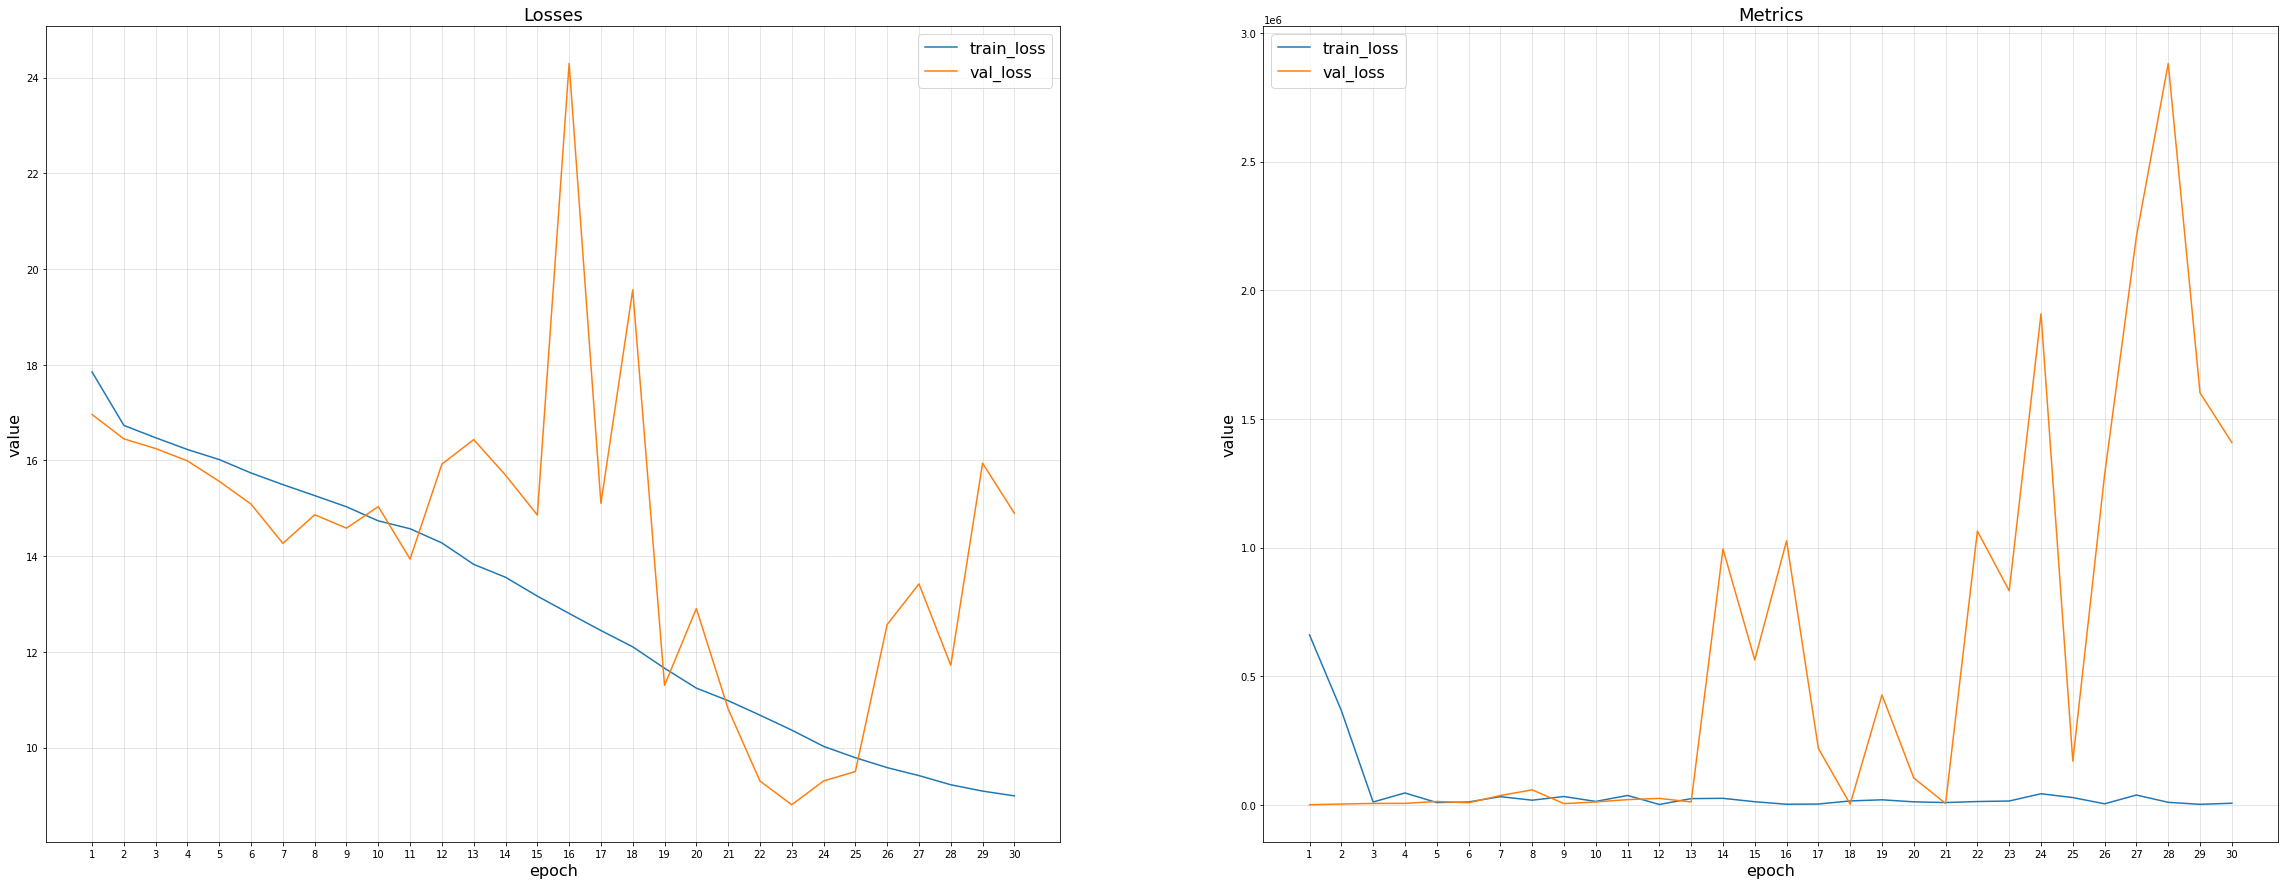

In [59]:
plot_history(history=history)

---

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [379]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [380]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)
        - стоить понимать, что при количестве точек < 10 000 на гпу медленнее обучать (раз в 10)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [80]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

In [82]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [160]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

train_X = (torch.stack([elem[0] for elem in train_data]))[3]
train_Y = torch.stack([elem[1] for elem in train_data])[3]

val_X = (torch.stack([elem[0] for elem in val_data]))[3]
val_Y = torch.stack([elem[1] for elem in val_data])[3]

val_Y_3D = torch.stack([elem[3] for elem in val_data])[3]
val_Y_pinv_As = torch.stack([elem[2] for elem in val_data])[3]

# Тут в любом случае надо выпрямлять, потому что там проблемы с размерностями внутри gpytorch, если какое матричное ядро имплементить, то лучше будет просто внутри функции обратно на матрицы перейти и уже на них считать число

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [163]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=CFG.K, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [165]:
class MinusLogLikelihoodLoss:
    '''

    Object for computing NLLLoss

    '''
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [151]:
class GPRMSELoss:
    '''
    
    object for calculation of MSE loss

    '''
    def __init__(self, likelihood):
        self.vanilla_MSE = MultiOutputMSELoss()
        self.likelihood = likelihood    # самописанные объекты изменяемые, поэтому этот имеет тот же id, что и глобальный likelihood

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object

        '''
        print(id(self.likelihood))
        mean_of_output = self.likelihood(model_output).mean

        return self.vanilla_MSE(mean_of_output, true_target)

In [172]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history: dict: {'loss': [losses], 'MSE': [MSEs]}

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())
        # history['sigma'].append((lower, upper))

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [191]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y, val_Y_pinv_As, val_Y_3D):
    '''
    
    One go dataset evaluation function

    Returns: mean, mean_3D, lower, upper

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        # output = model(val_X)
        # loss = loss_obj(output, val_Y)
        predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    mean_3D = torch.bmm(val_Y_pinv_As, torch.unsqueeze(mean.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
    mean_3D = torch.squeeze(mean_3D, -1)

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='sum').item() / mean.size(0)
    val_MSE_for_3D = F.mse_loss(input=mean_3D, target=val_Y_3D, reduction='sum').item() / mean_3D.size(0)

    print(f'val_MSE = {val_MSE}, val_MSE_for_3D = {val_MSE_for_3D}, val_RMSE_for_3D = {np.sqrt(val_MSE_for_3D)}')

    return mean, mean_3D, lower, upper

In [174]:
class FeatureExtractor(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, extracted_size=CFG.K * CFG.K):
        super().__init__()

        # self.FC = nn.Sequential(
        #     nn.Linear(CFG.K * CFG.K, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, extracted_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(CFG.K * CFG.K, 128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, extracted_size)
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):

        x = self.FC(x)

        return x

In [189]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=CFG.output_size)
feat_extractor = FeatureExtractor(extracted_size=32)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    # feature_extractor=feat_extractor
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00)

NLL_loss = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)
MSE_loss = GPRMSELoss(likelihood=likelihood)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

**Одно и то же значение для mean выводится в состоянии model.train(), потому что мы выбрали ConstMean и это типо и есть наше среднее, которое мы вычисляем по трейновому датасету**

In [190]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    
    loss_obj=NLL_loss,

    training_iterations=30,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.7187440395355225
Iter: 6, train_MSE = TODO, train_loss = 1.715226173400879
Iter: 11, train_MSE = TODO, train_loss = 1.710833191871643
Iter: 16, train_MSE = TODO, train_loss = 1.70915949344635
Iter: 21, train_MSE = TODO, train_loss = 1.7083622217178345
Iter: 26, train_MSE = TODO, train_loss = 1.7061927318572998


одинаковые аутпуты в eval будут, если у нас очень резко сетка становится широкой из низкоразмерных данных, если мы используем feature_extractor, то есть та же проблема, что была с сетками просто

In [ ]:
mean, mean_3D, lower, upper = GP_eval(

    likelihood=likelihood,
    model=model,

    optimizer=optimizer,
    loss_obj=NLL_loss,

    val_X=val_X,
    val_Y=val_Y,

    val_Y_pinv_As=val_Y_pinv_As,
    val_Y_3D=val_Y_3D
)

val_MSE = 0.0021715565964027686, val_MSE_for_3D = 0.0021715543888233325, val_RMSE_for_3D = 0.04659993979420287


In [ ]:
def make_predictions_and_plot_GPR(model, likelihood, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''

    if CFG.K != 1:
        return
        
    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        X_matrices = X_matrices.squeeze().detach()
        Y_target = Y_target.squeeze().detach()

    prediction_distr = likelihood(model(X_matrices))
    lower, upper = prediction_distr.confidence_region()
    Y_pred = prediction_distr.mean.squeeze().detach()
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]

    plt.figure(figsize=figsize)
    fig = plt.gcf()
    fig.suptitle(f'{criterion._get_name()}: {criterion(Y_pred, Y_target)}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)
        plt.scatter(X_matrices, Ys[i].squeeze(), label=f'Y(X) {name}')

        plt.xlabel(f'X', fontsize=18)
        plt.ylabel(f'Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

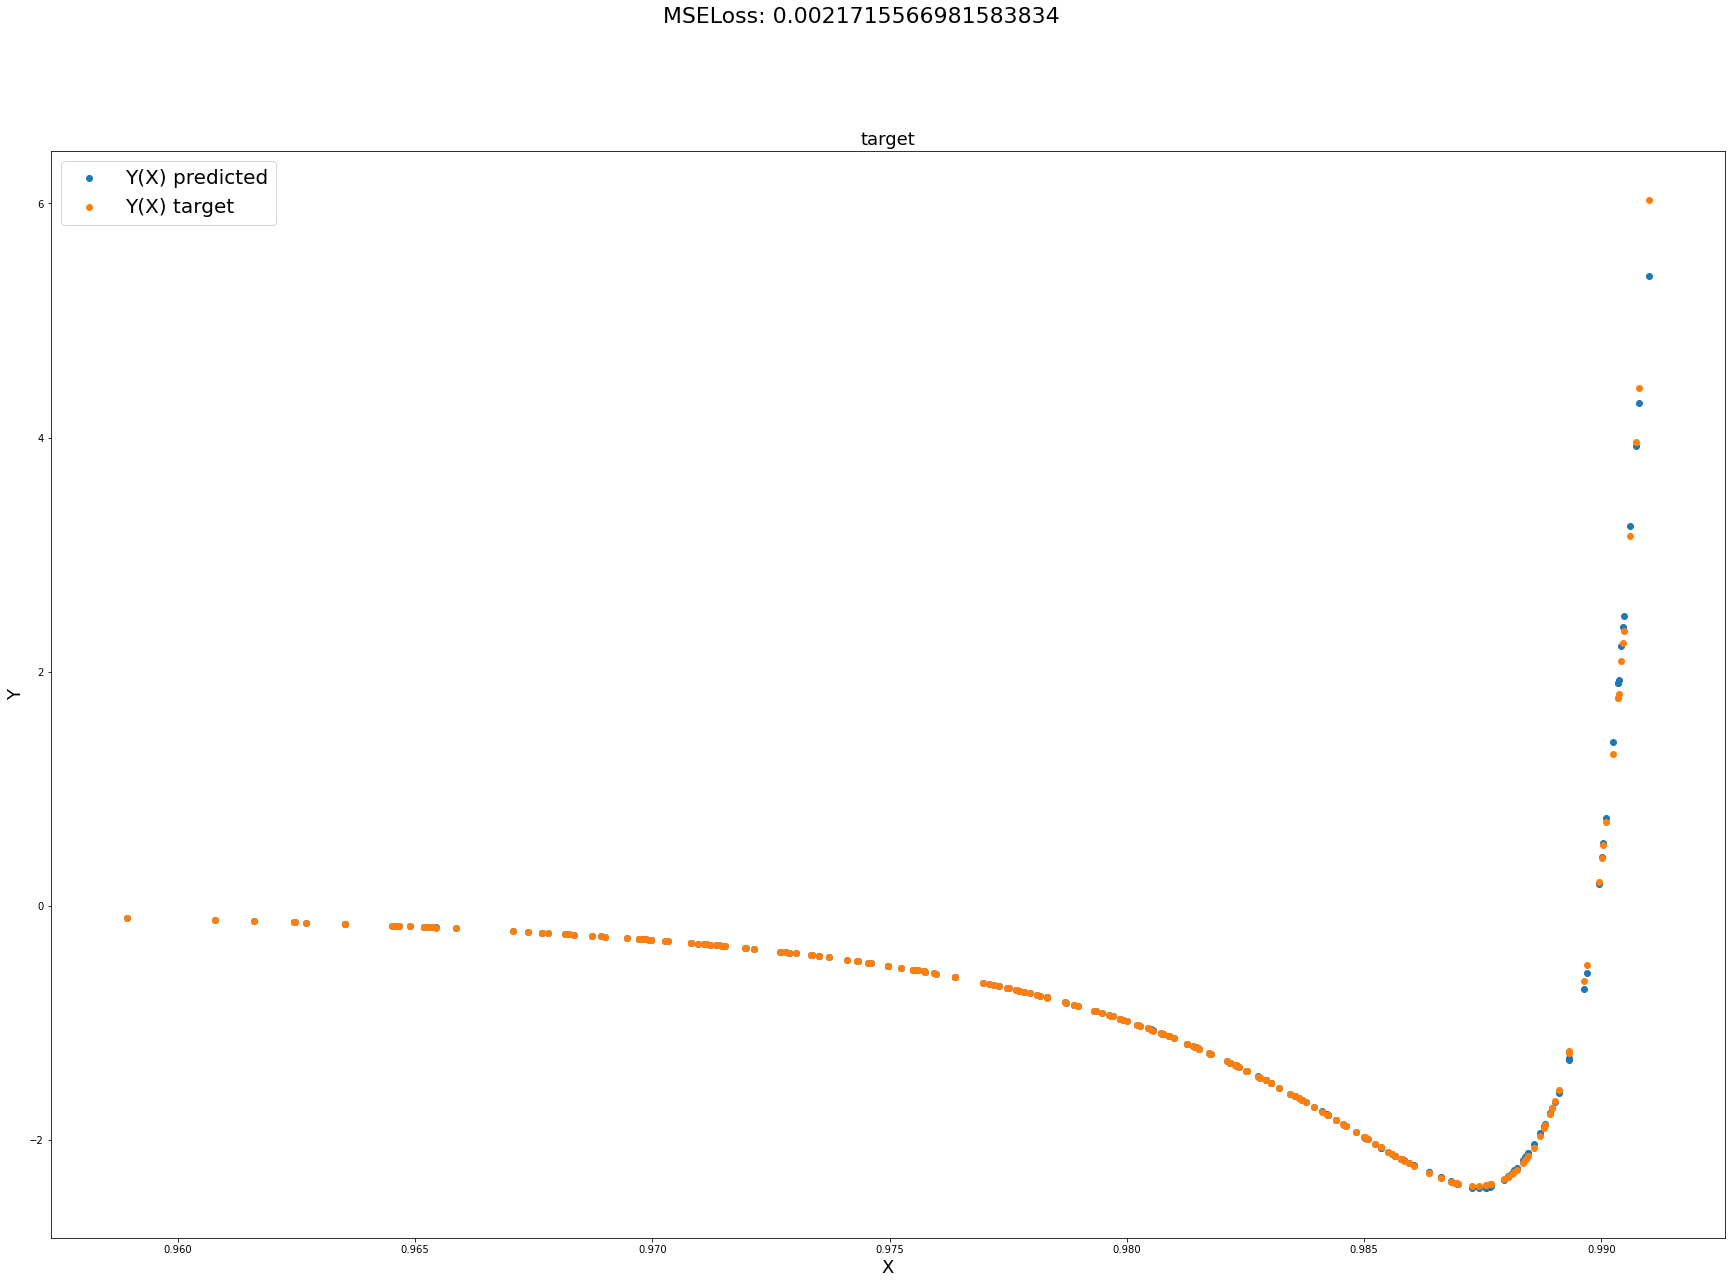

In [ ]:
make_predictions_and_plot_GPR(model=model, likelihood=likelihood, data=val_data, same_axis=True)

## 3.2) Stochastic Variational GP Regression (обучение GPR по мини батчам):

---

# Пока мои выводы / результаты: 

Update:

удаляю совсем маленькие силы из датасета - GPR стал обучаться совсем идеально, а вот сетка совсем нет...